# DCGAN 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data # dataloader 사용 

import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다.
import torchvision.transforms as T # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # GPU가 여러개 있을 때 0번만 쓰기로 하기 위함

## Quiz

In [5]:
#quiz 1 (torch.permute)

sample_array = np.random.randn(2000, 64, 64, 3)
sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
# 위 sample 을 (2000, 3, 64, 64)로 바꿔보세요.
sample_1 = sample.permute(0, 3, 1, 2) # permute: 순서 바꾸기 
print(sample_1.size())

# Dimension 순서 
# H, W, C - 보통
# C, H, W - pytorch 

# transpose는 차원이 2개일 때만 쓸 수 있다.
# 그러므로 그냥 permute을 쓰자. 

torch.Size([2000, 3, 64, 64])


In [8]:
# 위 sample 을 (2000, 64, 3, 64)로 바꿔보세요.
sample_2 = sample.permute(0, 1, 3, 2)
print(sample_2.size())

torch.Size([2000, 64, 3, 64])


In [5]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.permute(0,2,1)
print(a1.shape)
a2 = a.permute(1,2,0)
print(a2.shape)

torch.Size([5, 100, 20])
torch.Size([20, 100, 5])


In [9]:
#quiz 2 (torch.view)

sample = torch.from_numpy(np.array(sample_array))
# sample => (2000, 64, 64, 3).  
#위 sample 을 (2000, 64*64*3)으로 바꿔보세요.
sample_1 = sample.view(2000, -1)
print(sample_1.size())

#위 sample 을 (2000*64, 64*3)로 바꿔보세요.
sample_2 = sample.view(2000*64, -1)
print(sample_2.size())

torch.Size([2000, 12288])
torch.Size([128000, 192])


In [9]:
# hint
a = torch.FloatTensor(5,20,100)
a1 = a.view(2, 10, -1)
print(a1.shape)
a2 = a.view(-1,10, 200)
print(a2.shape)

torch.Size([2, 10, 500])
torch.Size([5, 10, 200])


## Convolution Layer

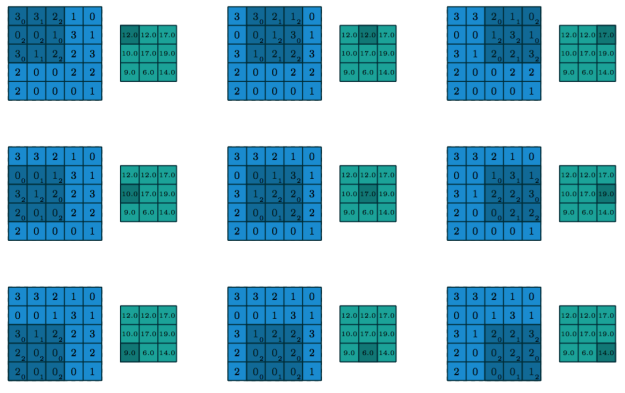

In [22]:
#quiz 3 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 512, 3, 1, 1) # input channel은 R, G, B로 3개! 
conv2 = nn.Conv2d(512, 128, 5, 2, 2) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 128, 32, 32)

torch.Size([16, 128, 32, 32])


In [25]:
#quiz 4 (torch.nn.conv)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, padding)
input1 = torch.zeros(16, 3, 64, 64)
conv1 = nn.Conv2d(3, 64, 3, 1, 1)
conv2 = nn.Conv2d(64, 512, 7, 4, 2) # quiz

out = conv1(input1)
out = conv2(out)
print(out.size())
# print(out.size) = (16, 512, 16, 16)

torch.Size([16, 512, 16, 16])


## Transpose Convolutional Layer

![Transpose Convolution](./imgs/1_Deconv.gif)

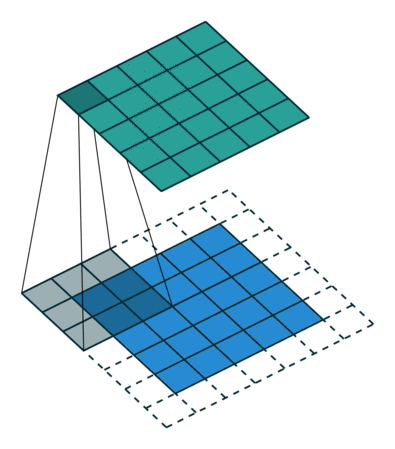

In [31]:
#quiz 5 (torch.nn.ConvTranspose2d)
# nn.Conv2d(in_channel, out_channel, filter_size, stride, pad)
input1 = torch.zeros(16, 100, 1, 1)
conv1 = nn.ConvTranspose2d(100, 512, 4, 2, 1) # 보통 (~, ~, 4, 2, 1) kernel, stride, padding 
conv2 = nn.ConvTranspose2d(512, 256, 4, 2, 1) # quiz

out = conv1(input1)
print(out.size())
out = conv2(out)
print(out.size())
# print(out.size()) = (16, 256, 4, 4)

torch.Size([16, 512, 2, 2])
torch.Size([16, 256, 4, 4])


# CIFAR10 DCGAN
## Data Loader 불러오기

In [32]:
def CIFAR10_DATA(root='./data/', download =True, batch_size=64, num_worker=1):
    print ("[+] Get the CIFAR-10 DATA")
    """
    torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있습니다.
    """
    transform = T.Compose([T.ToTensor(), # 얻어낸 데이터를 pytorch가 계산 할 수 있는 Tensor 로 변환해 줍니다. 
                           T.Normalize(mean=(0.5, 0.5, 0.5), # 0을 기준으로 정규화가 되어 있어야 좋다.
                                       std=(0.5, 0.5, 0.5))]) 
                            # 0~1범위의 수를 0.5로 빼주어 음수를 존재하게 하고 표준편차 0.5로 나누어주면 완료!
    
    cifar10_train = datasets.CIFAR10(root = root,  #root 는 데이터의 저장 위치 입니다. 
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보입니다. 
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부를 물어봅니다. 
    cifar10_test = datasets.CIFAR10(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 합니다. 
                                transform = transform,
                                download = True)
    """
    Data Loader 는 데이터와 batch size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 batch size 만큼 반환해주는 iterator입니다. 
    * Practical Guide : Batch size 는 어느정도가 좋나요? -- 클 수록 좋다는 소리가 있습니다. 하지만 gpu memeory 사이즈 한계에 의해 기본적으로 batch size 가 
    커질 수록 학습에 사용되는 gpu memory 사이즈가 큽니다. (Activation map을 저장해야 하기 때문입니다.) 기본적으로 2의 배수로 저장하는 것이 좋습니다.(Bit size 관련) 
    """
    trainDataLoader = data.DataLoader(dataset = cifar10_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보입니다. 여기서는 Training DATA를 제공합니다. 
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 합니다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보입니다. 
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼칩니다. 반드시 True 를 줘야 합니다. 
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker(프로세스)를 얼마나 추가하겠는가에 대한 정보입니다. 보통 4로 둔다.

    testDataLoader = data.DataLoader(dataset = cifar10_test, # Test Data Loader 이므로 Test Data를 인자로 전달해줍니다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어줍니다. 
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 줍니다. 
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return cifar10_train, cifar10_test, trainDataLoader, testDataLoader

In [33]:
trainDset, testDset, trainDataLoader, testDataLoader = CIFAR10_DATA(batch_size=64, num_worker=4)  # Data Loader 를 불러 옵니다. 

[+] Get the CIFAR-10 DATA


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
[+] Finished loading data & Preprocessing


## CIFAR10 Data 확인

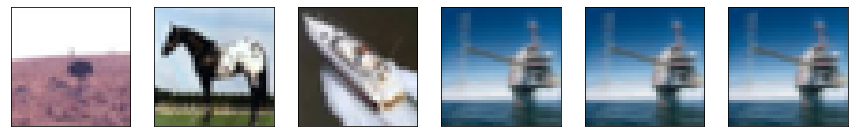

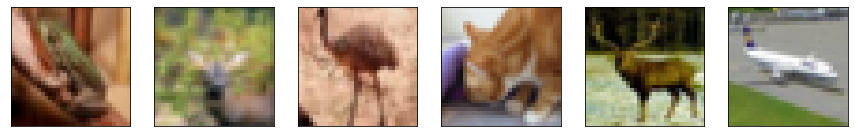

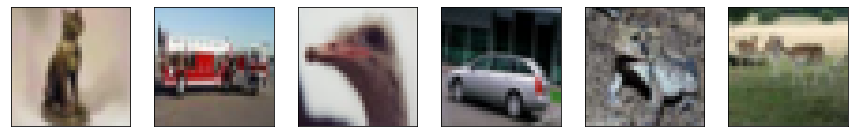

In [34]:
def show_images(image, n_row):
    for _ in range(n_row):  
        index=np.random.choice(64, 6)
        images =image.numpy()[index]
        plt.figure(figsize=(15,90))    
        for a in range(161, 167):    
            plt.subplot(a)
            plt.imshow(images[(a-161)].transpose(1,2,0))
            plt.xticks([])
            plt.yticks([])    
        plt.show()  

def denorm(x): # image의 scale을 변환하기 위한 함수
    out = (x + 1) / 2
    return out.clamp(0, 1)
        
for i, (image,_) in enumerate(trainDataLoader):
    show_images(denorm(image.squeeze()), 3)
    break

## Generator, Discriminator

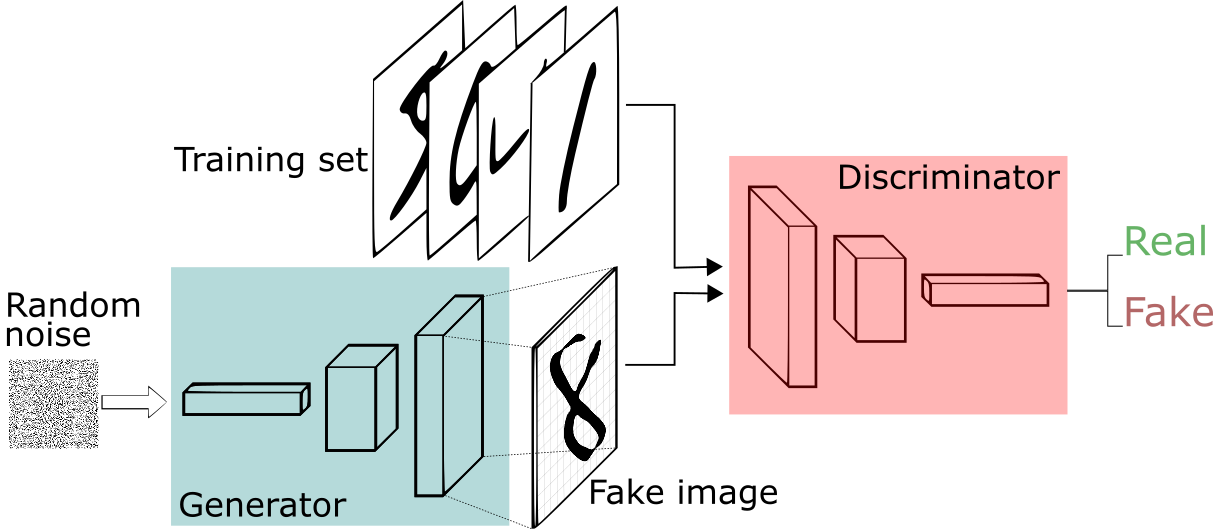

# DCGAN

In [35]:
'''
코드 단순화를 위한 함수들을 정의해 줍니다.
'''

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 convolution block 생성을 위한 함수입니다.
    Conv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    layers = []
    
    # Conv.
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out)) # c_out = channel의 개수 
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)
  
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    """ 
    코드 단순화를 위한 deconvolution block 생성을 위한 함수입니다.
    Deconv -> Batchnorm -> Activation function 으로 이어지는 일련의 레이어를 생성합니다.
    """
    
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
        
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
                
    return nn.Sequential(*layers)

In [36]:
class Generator(nn.Module):
    """Generator"""
    def __init__(self, z_dim=256, image_size=32, conv_dim=64):
        super(Generator, self).__init__()
        self.fc = deconv(z_dim, conv_dim*4, int(image_size/8), 1, 0, bn=False) # (B, 256, 4, 4)
        self.deconv1 = deconv(256, 128, 4, activation='relu') # (B, 128, 8, 8)
        self.deconv2 = deconv(128, 64, 4, activation='relu') # (B, 64, 16, 16)
        self.deconv3 = deconv(64, 3, 4, bn=False, activation='tanh') # (B, 3, 32, 32)
                # 'tanh'를 쓴 이유? : -1 ~ 1 사이에 있어야 image로 변환하기 편하기 때문
                # 여기서 sigmoid를 사용할 수 없는 이유 : sigmoid는 0 ~ 1의 scale을 가진다. 
                    # 하지만 데이터를 만들때 정규화를 해준 것으로 인해 sigmoid의 사용은 적합치 않다. (뭔말이야...)
    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = self.fc(z)                            
        out = self.deconv1(out)
        out = self.deconv2(out)
        out = self.deconv3(out)
        return out

In [37]:
g = Generator()
z = torch.randn(16, 256)
out = g(z)
print(out.shape)

torch.Size([16, 3, 32, 32])


In [38]:
class Discriminator(nn.Module):
    """Discriminator"""
    def __init__(self, image_size=32, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = conv(3, 64, 4, bn=False) # (B, 64, 16, 16) bn=False
                        # 3 -> RGB
        self.conv2 = conv(64, 128, 4) # (B, 128, 8, 8)
        self.conv3 = conv(128, 256, 4) # (B, 256, 4, 4)
        self.fc = conv(conv_dim*4, 1, int(image_size/8), 1, 0, False) # (B, 1, 1, 1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = torch.sigmoid(self.fc(out).squeeze()) # Sigmoid 함수를 사용해야 합니다.
        return out

In [39]:
# build model
G = Generator(z_dim=256, image_size=32, conv_dim=64).to('cpu') # cuda()
D = Discriminator(image_size=32, conv_dim=64).to('cpu') # cuda()

In [42]:
img = torch.randn(16, 3, 32, 32).to('cpu') # (batch, channel, input, output)
out = D(img).to('cpu') 
print(out.shape)
print(out)

torch.Size([16])
tensor([0.6013, 0.6238, 0.6121, 0.6417, 0.4717, 0.5453, 0.4926, 0.5691, 0.6673,
        0.6149, 0.5625, 0.4761, 0.6350, 0.5867, 0.5557, 0.6687],
       grad_fn=<SigmoidBackward0>)


## Train DCGAN

Epoch [0/100], Step[300/782], d_loss: 0.9556, g_loss: 1.5192


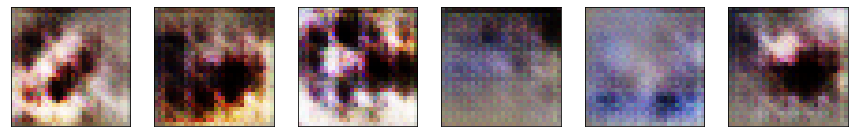

Epoch [0/100], Step[600/782], d_loss: 0.7051, g_loss: 1.1030


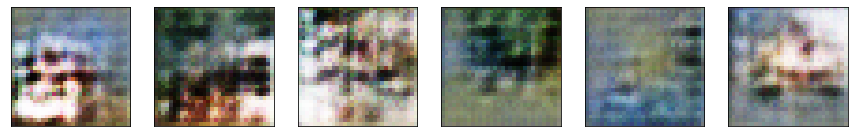

Epoch [1/100], Step[300/782], d_loss: 0.7715, g_loss: 0.9660


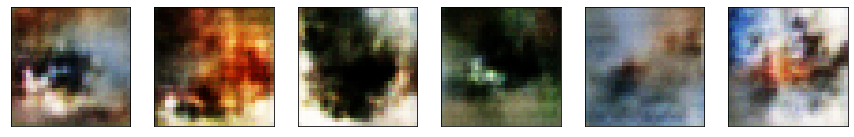

Epoch [1/100], Step[600/782], d_loss: 0.6990, g_loss: 0.8541


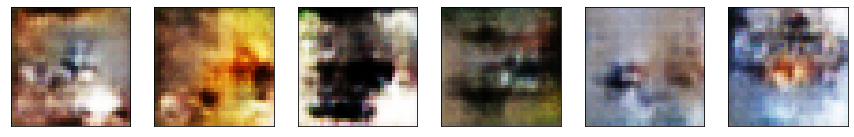

Epoch [2/100], Step[300/782], d_loss: 0.7347, g_loss: 1.1959


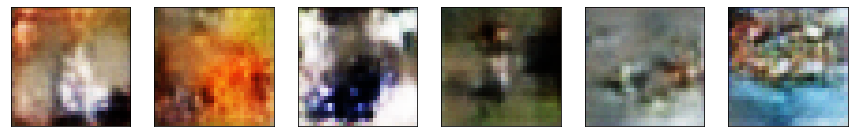

Epoch [2/100], Step[600/782], d_loss: 0.7120, g_loss: 1.1164


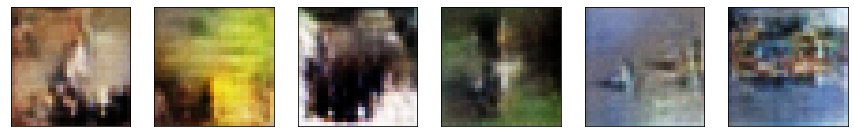

Epoch [3/100], Step[300/782], d_loss: 0.9332, g_loss: 0.8032


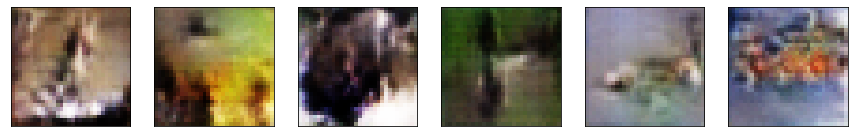

KeyboardInterrupt: 

In [44]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999]) # learning_rate=0.0002, beta1=0.5, beta2=0.999

# 학습이 잘 되고 있는지 확인하기 위한 예시 (이미지 표시)
fixed_z = torch.randn(6,256).to('cpu') # cuda()

# Training
for epoch in range(10):
    for i, (images, _) in enumerate(trainDataLoader):
        G.train() # 학습시킨다(X) 학습 모드(학습 단계)로 전환시키겠다(O) 
        D.train()
        
        # Build mini-batch dataset
        batch_size = images.size(0)
        images = images.to('cpu') # cuda()
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size).to('cpu') # cuda()
        fake_labels = torch.zeros(batch_size).to('cpu') # cuda()

        #============= Train the discriminator =============#
        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels) # Discriminator가 real image를 1(Real)로 예측하도록 학습
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, 256).to('cpu') # cuda()
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels) # Discriminator가 fake image를 0(Fake)으로 예측하도록 학습
        fake_score = outputs

        # Backprop + Optimize
        d_loss = d_loss_real + d_loss_fake
        D.zero_grad() # 누적되어 있던 값들 초기화. 0으로 비워줌 
        d_loss.backward()
        d_optimizer.step() # gradient 만큼 D update

        #=============== Train the generator ===============#
        # Compute loss with fake images
        z = torch.randn(batch_size, 256).to('cpu') # cuda()
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels) # Generator에서 생성한 fake image가 Discriminator에서 1(Real)로 예측하도록 학습

        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad() # 위에 해주었으니 굳이 안 넣어도 무방 
        g_loss.backward()
        g_optimizer.step() # gradient 만큼 G update 

        if (i+1) % 300 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f' 
                  %(epoch, 100, i+1, len(trainDataLoader), d_loss.item(), g_loss.item()))
            print('======================================================================================================')
            
            G.eval() # 평가모드로 전환! 
            fake_images = G(fixed_z)
            fake_images = denorm(fake_images)
            
            images_to_show = fake_images.data.cpu().numpy().transpose((0,2,3,1))
            images_row = images_to_show[:6] 

            plt.figure(figsize=(15,75))
            for a in range(161, 167):    
                plt.subplot(a)
                plt.imshow(images_row[a-161])
                plt.xticks([])
                plt.yticks([])
            plt.show()

## Save checkpoints

In [ ]:
torch.save(G.state_dict(),'./model/dcgan_generator.pckl')
torch.save(D.state_dict(),'./model/dcgan_discriminator.pckl')